In [1]:
from PIL import Image, ImageFont
import os
import torch
import glob
import sys
import warnings
import matplotlib.pyplot as plt
import clip
import numpy as np

In [2]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s',pretrained=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Using cache found in /home/zakaria/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-15 Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3011MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [3]:
img1 = Image.open('jack.jpg').convert("RGB")
crop_results = model(img1)
results = crop_results.crop(save=False)
clip_model , preprocess = clip.load('ViT-B/32',device)

In [4]:
preprocessed_images = torch.stack([preprocess(Image.fromarray(result['im'])) for result in results])
search_query = "jack daniels"

In [5]:
preprocessed_images = torch.tensor(np.stack(preprocessed_images)).cuda()
with torch.no_grad(): 
   images_features = clip_model.encode_image(preprocessed_images)
   text_encoded = clip_model.encode_text(clip.tokenize(search_query).to(device)) 
images_features /= images_features.norm(dim=-1, keepdim=True)
text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

similarity = text_encoded.cpu().numpy() @ images_features.cpu().numpy().T

In [6]:
def similarity_top(results,similarity_list,N):
  clip_results = zip(range(len(similarity_list)), similarity_list)
  clip_results = sorted(clip_results, key=lambda x: x[1],reverse= True)
  top_images = []
  scores=[]
  for index,score in clip_results[:N]:
    scores.append(score)
    top_images.append(results[index]['im'])
  return scores,top_images  

scores,imgs= similarity_top(results,similarity[0],N=1)

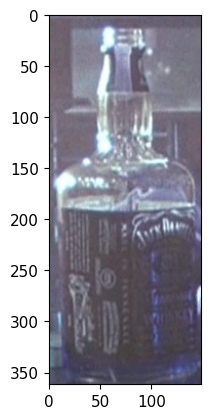

In [7]:
%matplotlib inline
plt.imshow(imgs[0])
plt.show()

In [8]:
del similarity, preprocessed_images, search_query, results,crop_results, img1, images_features,imgs,scores,text_encoded
torch.cuda.empty_cache()